# Laboratorium: Histogram i progowanie obrazów

## 1. Teoria

### 1.1 Histogram obrazu

**Histogram** to graficzna reprezentacja rozkładu jasności pikseli w obrazie. Dla obrazu w skali szarości (8-bitowego) histogram pokazuje, ile pikseli ma daną wartość jasności (0–255).

**Intuicja Feynmana:**
> Wyobraź sobie, że masz 256 pudełek ponumerowanych od 0 do 255. Dla każdego piksela w obrazie wrzucasz kulkę do pudełka odpowiadającego jego jasności. Na końcu liczysz kulki w każdym pudełku – to jest histogram!

**Zastosowania:**
- Analiza kontrastu obrazu
- Wykrywanie niedoświetlenia/prześwietlenia
- Podstawa do operacji poprawy jakości (rozciąganie, wyrównywanie)
- Segmentacja (progowanie)

**Dystrybuanta (CDF – Cumulative Distribution Function):**
- Suma skumulowana histogramu
- Dla każdego poziomu jasności *i* pokazuje, ile pikseli ma jasność ≤ *i*
- Znormalizowana do [0, 1]
- Wykorzystywana w wyrównywaniu histogramu

---

### 1.2 Rozciąganie histogramu (Contrast Stretching)

**Cel:** Zwiększenie kontrastu obrazu poprzez rozciągnięcie zakresu jasności do pełnego dostępnego zakresu [0, 255].

**Metoda min–max (linearyzacja):**

$$
I_{out}(x,y) = \frac{I_{in}(x,y) - \min(I_{in})}{\max(I_{in}) - \min(I_{in})} \times (out_{max} - out_{min}) + out_{min}
$$

gdzie:
- $I_{in}$ – obraz wejściowy
- $\min(I_{in})$, $\max(I_{in})$ – minimalna i maksymalna wartość jasności w obrazie
- $out_{min}$, $out_{max}$ – docelowy zakres (zazwyczaj 0 i 255)

**Metoda percentylowa:**
- Zamiast używać globalnego min/max, używamy percentyli (np. 1% i 99%)
- Eliminuje wpływ pojedynczych outlierów (bardzo jasne/ciemne piksele)
- Bardziej odporna na szum

**Wizualizacja:**
```
Przed rozciąganiem:        Po rozciąganiu:
Histogram skupiony         Histogram rozłożony
w wąskim zakresie          na pełnym zakresie [0,255]
    |█|                        |  █  |
    |█|                        | █ █ |
    |█|          →             |█   █|
    |█|                        |     |
  ------                     --------
  50 150                     0     255
```

---

### 1.3 Progowanie globalne

**Progowanie** to operacja segmentacji obrazu polegająca na podziale pikseli na dwie klasy (obiekt/tło) na podstawie wartości progowej *T*.

**Progowanie binarne:**
$$
I_{out}(x,y) = \begin{cases}
255 & \text{jeśli } I_{in}(x,y) \geq T \\
0 & \text{jeśli } I_{in}(x,y) < T
\end{cases}
$$

**Metoda Otsu:**
- Automatyczny dobór progu *T*
- Maksymalizuje wariancję międzyklasową (różnicę między obiektami a tłem)
- Zakłada rozkład bimodalny (dwa wyraźne piki w histogramie)

**Algorytm Otsu:**
1. Oblicz histogram obrazu
2. Dla każdego możliwego progu *t* = 0, 1, ..., 255:
   - Podziel piksele na dwie klasy: C₀ (jasność < *t*) i C₁ (jasność ≥ *t*)
   - Oblicz wagi klas: $w_0$, $w_1$ (proporcje pikseli)
   - Oblicz średnie jasności klas: $\mu_0$, $\mu_1$
   - Oblicz wariancję międzyklasową: $\sigma^2_b = w_0 \cdot w_1 \cdot (\mu_0 - \mu_1)^2$
3. Wybierz *t*, dla którego $\sigma^2_b$ jest maksymalna

---

### 1.4 Progowanie adaptacyjne (lokalne)

**Problem progowania globalnego:**
- Jeden próg dla całego obrazu
- Nie radzi sobie z nierównomiernym oświetleniem

**Progowanie adaptacyjne:**
- Próg obliczany lokalnie dla każdego piksela
- Uwzględnia sąsiedztwo piksela (okno *block_size* × *block_size*)

**Metoda średniej:**
$$
T(x,y) = \text{mean}(\text{okno}(x,y)) - C
$$
gdzie *C* to stała korekcyjna (domyślnie 0).

**Optymalizacja przez integral image:**
- Suma pikseli w dowolnym prostokącie w O(1)
- Przyspiesza obliczenia dla dużych okien

---

### 1.5 Oszacowanie progu z histogramu

**Metoda A: Dwa piki histogramu**
1. Wygładź histogram (np. średnią ruchomą)
2. Znajdź dwa największe maksima lokalne (piki)
3. Próg = minimum histogramu między pikami

**Metoda B: ISODATA (iteracyjna)**
1. Początkowy próg *T* = średnia jasność obrazu
2. Podziel piksele na dwie klasy: C₀ (< *T*) i C₁ (≥ *T*)
3. Oblicz średnie $\mu_0$ i $\mu_1$ dla obu klas
4. Nowy próg: $T_{new} = (\mu_0 + \mu_1) / 2$
5. Powtarzaj kroki 2–4, aż *T* się ustabilizuje (różnica < ε)

**Wizualizacja:**
```
Histogram bimodalny:

  █           █
  █     ↓     █      ← Próg (minimum między pikami)
  █    min    █
  █           █
-----------------
  Tło    Obiekt
```

---


## 2. Kod startowy

### 2.1 Import bibliotek


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen
import os

# Konfiguracja wyświetlania
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

### 2.2 Funkcje pomocnicze

In [2]:
def rgb_to_gray(image):
    """
    Konwertuje obraz RGB do skali szarości.
    Wzór: Y = 0.2126*R + 0.7152*G + 0.0722*B (ITU-R BT.709)
    """
    if len(image.shape) == 3:
        return np.dot(image[...,:3], [0.2126, 0.7152, 0.0722]).astype(np.uint8)
    return image

def load_image_gray(path_or_url):
    """Wczytuje obraz i konwertuje do skali szarości."""
    if path_or_url.startswith('http'):
        img = Image.open(urlopen(path_or_url))
    else:
        img = Image.open(path_or_url)
    img_array = np.array(img)
    return rgb_to_gray(img_array)

def show_images(images, titles, cmap='gray', figsize=(15, 5)):
    """Wyświetla wiele obrazów obok siebie."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def generate_test_images():
    """Generuje obrazy testowe."""
    # Obraz z gradientem
    gradient = np.linspace(0, 255, 256).astype(np.uint8)
    gradient = np.tile(gradient, (100, 1))

    # Obraz bimodalny (dwa poziomy)
    bimodal = np.zeros((100, 256), dtype=np.uint8)
    bimodal[:, :128] = 80
    bimodal[:, 128:] = 180

    # Obraz z outlierami
    outliers = np.random.randint(100, 150, (100, 256), dtype=np.uint8)
    outliers[10:20, 10:20] = 255  # jasne outliery
    outliers[80:90, 230:240] = 0  # ciemne outliery

    return gradient, bimodal, outliers

### 2.3 Wczytanie obrazu testowego

Rozmiar obrazu Lena: (256, 256)
Typ danych: uint8
Zakres wartości: [15, 241]


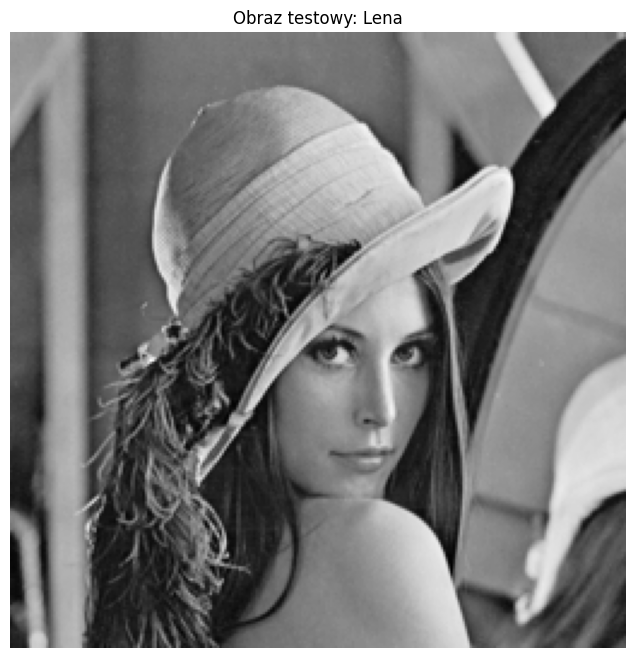

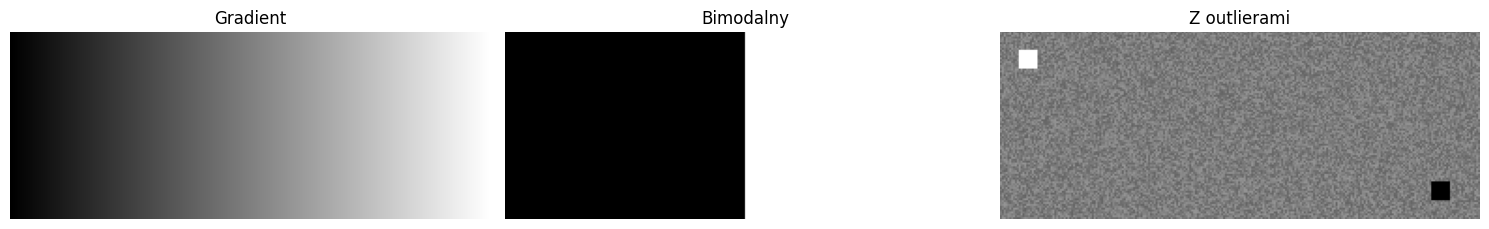

In [3]:
# Wczytanie obrazu Lena
try:
    lena_url = 'https://raw.githubusercontent.com/kbor89/TWiPO/main/images/lenna.png'
    lena = load_image_gray(lena_url)
    # Zmniejszenie rozmiaru dla szybszych obliczeń
    lena_small = np.array(Image.fromarray(lena).resize((256, 256)))
    print(f"Rozmiar obrazu Lena: {lena_small.shape}")
    print(f"Typ danych: {lena_small.dtype}")
    print(f"Zakres wartości: [{lena_small.min()}, {lena_small.max()}]")
    plt.imshow(lena_small, cmap='gray')
    plt.title('Obraz testowy: Lena')
    plt.axis('off')
    plt.show()
except:
    print("Nie udało się pobrać obrazu Lena. Użyj własnego obrazu.")
    lena_small = None

# Generowanie obrazów testowych
gradient, bimodal, outliers = generate_test_images()
show_images([gradient, bimodal, outliers], 
            ['Gradient', 'Bimodalny', 'Z outlierami'])

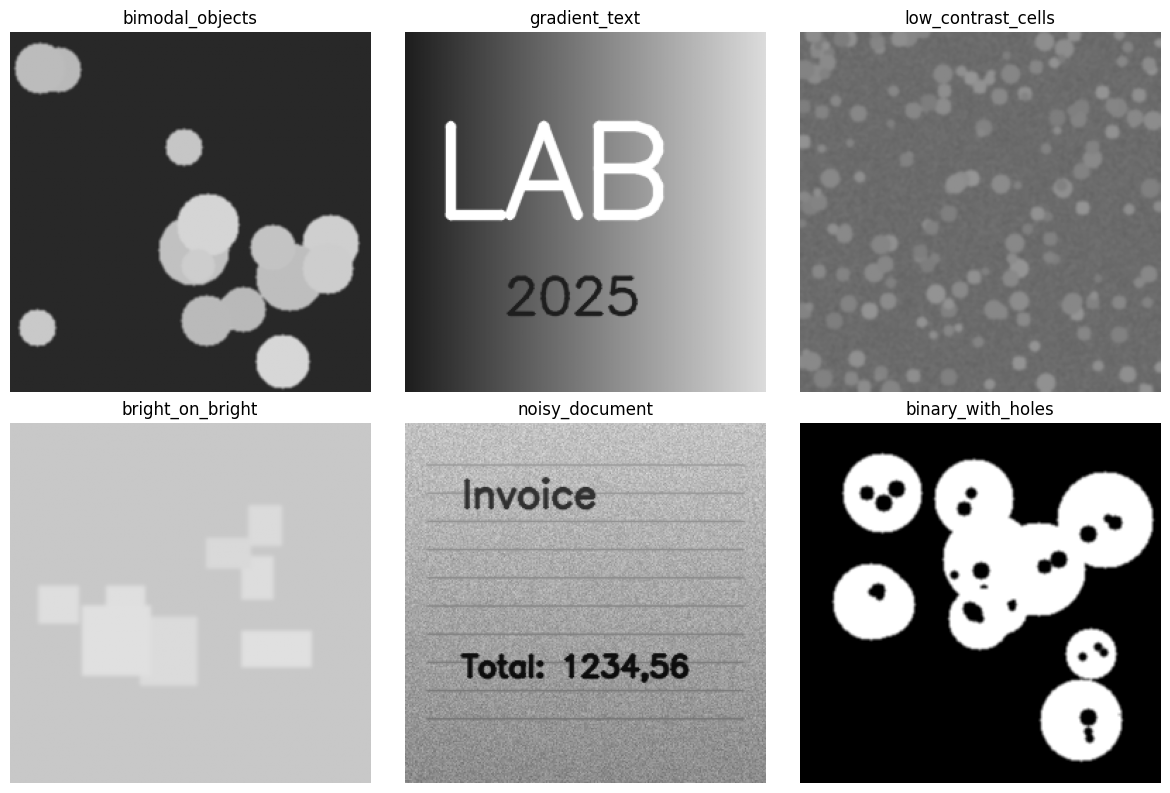

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def show_images(imgs, titles=None, cmap='gray', cols=3, figsize=(12,8)):
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
        if titles: plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def make_bimodal_objects(shape=(256,256), seed=0):
    rng = np.random.default_rng(seed)
    img = np.full(shape, 40, np.uint8)
    # jasne krążki
    for _ in range(15):
        r = rng.integers(12, 28)
        cy, cx = rng.integers(r+2, min(shape)-r-2, size=2)
        yy, xx = np.ogrid[:shape[0], :shape[1]]
        mask = (yy-cy)**2 + (xx-cx)**2 <= r*r
        img[mask] = 200 + rng.integers(-15, 16)
    # lekki szum
    img = cv2.GaussianBlur(img, (3,3), 0)
    return img

def make_gradient_with_text(shape=(256,256)):
    # silny gradient poziomy
    x = np.linspace(30, 220, shape[1], dtype=np.uint8)
    img = np.tile(x, (shape[0], 1))
    # tekst jako trudny obiekt
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.putText(img_color, 'LAB', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 6, cv2.LINE_AA)
    cv2.putText(img_color, '2025', (70,200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (30,30,30), 2, cv2.LINE_AA)
    return cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

def make_low_contrast_cells(shape=(256,256), seed=1):
    rng = np.random.default_rng(seed)
    base = rng.integers(95, 120, size=shape, dtype=np.uint8)
    for _ in range(180):
        r = rng.integers(3, 8)
        cy, cx = rng.integers(0, shape[0]), rng.integers(0, shape[1])
        cv2.circle(base, (int(cx), int(cy)), int(r), int(rng.integers(125, 150)), -1)
    base = cv2.GaussianBlur(base, (5,5), 1.0)
    return base

def make_bright_on_bright(shape=(256,256), seed=2):
    rng = np.random.default_rng(seed)
    img = np.full(shape, 200, np.uint8)
    for _ in range(8):
        x1, y1 = rng.integers(10, 200, size=2)
        w, h = rng.integers(20, 50, size=2)
        cv2.rectangle(img, (x1,y1), (min(x1+w,255), min(y1+h,255)), 220 + int(rng.integers(-5,6)), -1)
    img = cv2.GaussianBlur(img, (7,7), 0)
    return img

def make_noisy_doc(shape=(256,256), seed=3):
    rng = np.random.default_rng(seed)
    bg = rng.integers(180, 210, size=shape, dtype=np.uint8)
    noise = rng.normal(0, 7, size=shape).astype(np.int16)
    img = np.clip(bg.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    # linie i tekst
    for i in range(30, 230, 20):
        cv2.line(img, (15,i), (240,i), 160, 1, cv2.LINE_AA)
    cv2.putText(img, 'Invoice', (40,60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 60, 2, cv2.LINE_AA)
    cv2.putText(img, 'Total: 1234,56', (40,180), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 50, 2, cv2.LINE_AA)
    # cień: gradient ukośny
    gy = np.linspace(0, 55, shape[0]).astype(np.uint8)
    shade = np.tile(gy, (shape[1],1)).T
    img = np.clip(img - shade, 0, 255).astype(np.uint8)
    return img

def make_binary_with_holes(shape=(256,256), seed=4):
    rng = np.random.default_rng(seed)
    mask = np.zeros(shape, np.uint8)
    for _ in range(12):
        r = rng.integers(15, 35)
        cy, cx = rng.integers(r+5, min(shape)-r-5, size=2)
        cv2.circle(mask, (int(cx), int(cy)), int(r), 255, -1)
        # dziury
        for _ in range(3):
            rr = rng.integers(3, 7)
            ang = rng.uniform(0, 2*np.pi)
            off = rng.integers(0, r-5)
            hy = int(cy + off*np.sin(ang))
            hx = int(cx + off*np.cos(ang))
            cv2.circle(mask, (hx, hy), int(rr), 0, -1)
    # zamiana na odcienie (lekki blur -> utrudnienie)
    img = cv2.GaussianBlur(mask, (3,3), 0)
    return img

def load_embedded_test_images():
    imgs = [
        ('bimodal_objects', make_bimodal_objects()),
        ('gradient_text', make_gradient_with_text()),
        ('low_contrast_cells', make_low_contrast_cells()),
        ('bright_on_bright', make_bright_on_bright()),
        ('noisy_document', make_noisy_doc()),
        ('binary_with_holes', make_binary_with_holes()),
    ]
    return imgs

# Przykład użycia:
dataset = load_embedded_test_images()
titles = [name for name, _ in dataset]
imgs = [img for _, img in dataset]
show_images(imgs, titles, cols=3)

---

## 3. Zadania dla studentów

### Zadanie 1: Histogram obrazu 8-bitowego

#### 1.1 Implementacja funkcji `compute_histogram`

**Zadanie:** Zaimplementuj funkcję obliczającą histogram obrazu w skali szarości.

**Wymagania:**
- Wejście: obraz uint8 lub float w [0,1]
- Wyjście: tablica 256 elementów (zliczenia) + wektor binów
- Bez użycia `np.histogram` (własna implementacja)


In [ ]:
# TODO: Zaimplementuj funkcję compute_histogram
def compute_histogram(img_gray, bins=256):
    """
    Oblicza histogram obrazu w skali szarości.

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz w skali szarości (uint8 lub float [0,1])
    bins : int
        Liczba binów (domyślnie 256)

    Zwraca:
    -------
    hist : numpy.ndarray
        Histogram (tablica zliczeń)
    bin_edges : numpy.ndarray
        Krawędzie binów
    """
    # TODO: Konwersja do uint8 jeśli float
    # TODO: Inicjalizacja tablicy histogramu (256 zer)
    # TODO: Zliczanie pikseli (pętla lub np.bincount)
    # TODO: Zwrócenie histogramu i zakresu binów
    pass

# Test
if lena_small is not None:
    hist, bins = compute_histogram(lena_small)
    print(f"✓ Suma zliczeń: {hist.sum()} == {lena_small.size}")
    assert hist.sum() == lena_small.size, "Błąd: suma zliczeń != liczba pikseli"
    print("Test passed!")
    
    for k in bins:
        print(bins[k], ":", hist[k])

In [5]:
# ROZWIĄZANIE 1.1 (do usunięcia przed zajęciami)
def compute_histogram(img_gray, bins=256):
    # Konwersja do uint8
    if img_gray.dtype == np.float32 or img_gray.dtype == np.float64:
        img_gray = (img_gray * 255).astype(np.uint8)

    # Inicjalizacja histogramu
    hist = np.zeros(bins, dtype=np.int32)

    # Zliczanie (szybka metoda)
    hist = np.bincount(img_gray.ravel(), minlength=bins)

    # Zakres binów
    bin_edges = np.arange(bins)

    return hist, bin_edges

# Test
if lena_small is not None:
    hist, bins = compute_histogram(lena_small)
    print(f"✓ Suma zliczeń: {hist.sum()} == {lena_small.size}")
    assert hist.sum() == lena_small.size, "Błąd: suma zliczeń != liczba pikseli"
    print("Test passed!")
    
    for k in bins:
        print(bins[k], ":", hist[k])
        

✓ Suma zliczeń: 65536 == 65536
Test passed!
0 : 0
1 : 0
2 : 0
3 : 0
4 : 0
5 : 0
6 : 0
7 : 0
8 : 0
9 : 0
10 : 0
11 : 0
12 : 0
13 : 0
14 : 0
15 : 2
16 : 1
17 : 2
18 : 3
19 : 6
20 : 3
21 : 16
22 : 19
23 : 29
24 : 40
25 : 47
26 : 69
27 : 83
28 : 97
29 : 129
30 : 155
31 : 178
32 : 209
33 : 294
34 : 329
35 : 346
36 : 454
37 : 495
38 : 532
39 : 528
40 : 532
41 : 577
42 : 535
43 : 521
44 : 530
45 : 491
46 : 457
47 : 433
48 : 392
49 : 344
50 : 304
51 : 281
52 : 274
53 : 283
54 : 248
55 : 236
56 : 221
57 : 225
58 : 235
59 : 199
60 : 246
61 : 219
62 : 209
63 : 273
64 : 243
65 : 235
66 : 229
67 : 253
68 : 246
69 : 247
70 : 222
71 : 230
72 : 238
73 : 217
74 : 244
75 : 242
76 : 267
77 : 231
78 : 265
79 : 271
80 : 300
81 : 260
82 : 318
83 : 324
84 : 378
85 : 384
86 : 397
87 : 496
88 : 565
89 : 570
90 : 527
91 : 464
92 : 486
93 : 518
94 : 437
95 : 394
96 : 378
97 : 417
98 : 339
99 : 315
100 : 333
101 : 306
102 : 323
103 : 304
104 : 312
105 : 355
106 : 386
107 : 385
108 : 354
109 : 381
110 : 439
111 : 

#### 1.2 Wizualizacja histogramu

**Zadanie:** Zaimplementuj funkcję rysującą histogram słupkowy.

In [ ]:
# TODO: Zaimplementuj funkcję plot_histogram
def plot_histogram(hist, bins=None, title="Histogram", show_cdf=False):
    """
    Rysuje histogram słupkowy.

    Parametry:
    ----------
    hist : numpy.ndarray
        Histogram (zliczenia)
    bins : numpy.ndarray, optional
        Krawędzie binów
    title : str
        Tytuł wykresu
    show_cdf : bool
        Czy nałożyć CDF (dystrybuantę)
    """
    # TODO: Stworzenie figury
    # TODO: Narysowanie słupków (plt.bar lub plt.plot)
    # TODO: Opcjonalnie: nałożenie CDF na drugi oś Y
    # TODO: Opisy osi, tytuł
    pass

# Test
img_test = make_noisy_doc() 
hist, bins = compute_histogram(img_test)
plot_histogram(hist, title="Histogram noisy_doc", show_cdf=True)

if lena_small is not None:
    hist, bins = compute_histogram(lena_small)
    plot_histogram(hist, title="Histogram Leny", show_cdf=True)
    show_images([img_test,lena_small])

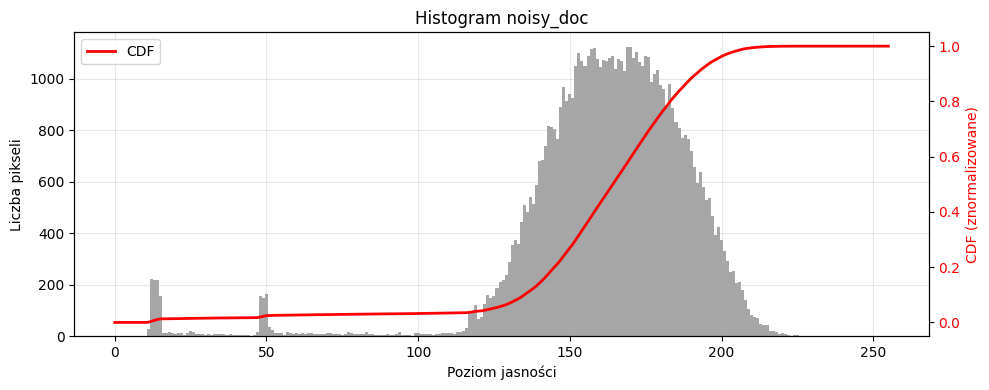

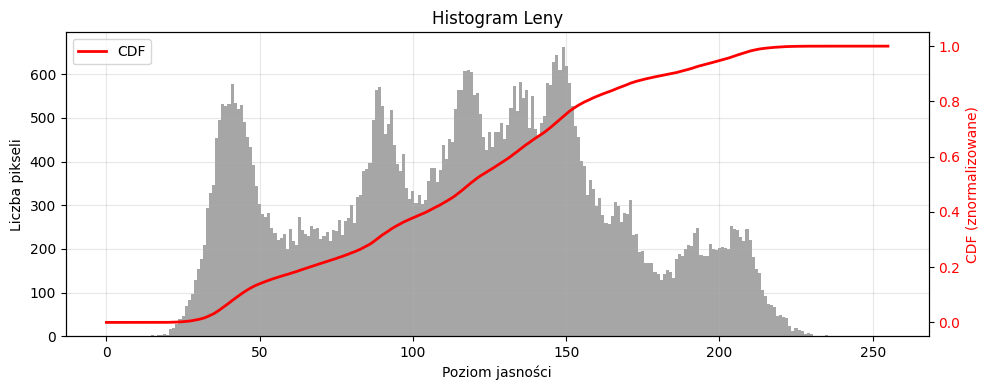

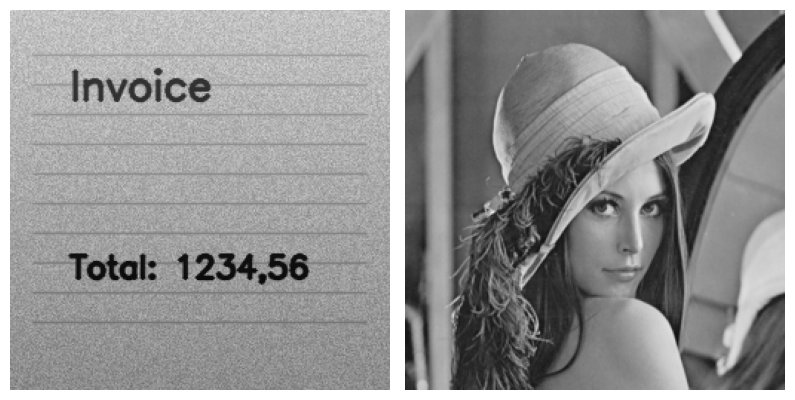

In [6]:
# ROZWIĄZANIE 1.2
def plot_histogram(hist, bins=None, title="Histogram", show_cdf=False):
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Histogram
    x = np.arange(len(hist))
    ax1.bar(x, hist, width=1.0, color='gray', alpha=0.7)
    ax1.set_xlabel('Poziom jasności')
    ax1.set_ylabel('Liczba pikseli')
    ax1.set_title(title)
    ax1.grid(alpha=0.3)

    # Opcjonalnie CDF
    if show_cdf:
        cdf = np.cumsum(hist) / hist.sum()
        ax2 = ax1.twinx()
        ax2.plot(x, cdf, 'r-', linewidth=2, label='CDF')
        ax2.set_ylabel('CDF (znormalizowane)', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.legend()

    plt.tight_layout()
    plt.show()

# Test
img_test = make_noisy_doc() 
hist, bins = compute_histogram(img_test)
plot_histogram(hist, title="Histogram noisy_doc", show_cdf=True)

if lena_small is not None:
    hist, bins = compute_histogram(lena_small)
    plot_histogram(hist, title="Histogram Leny", show_cdf=True)
    show_images([img_test,lena_small])
    


#### 1.3 Dystrybuanta (CDF)

**Zadanie:** Zaimplementuj funkcję obliczającą skumulowaną dystrybuantę histogramu.

In [ ]:
# TODO: Zaimplementuj funkcję cumulative_histogram
def cumulative_histogram(hist):
    """
    Oblicza dystrybuantę (CDF) znormalizowaną do [0, 1].

    Parametry:
    ----------
    hist : numpy.ndarray
        Histogram

    Zwraca:
    -------
    cdf : numpy.ndarray
        Dystrybuanta znormalizowana
    """
    # TODO: Suma skumulowana (np.cumsum)
    # TODO: Normalizacja do [0, 1]
    pass

# Test
if lena_small is not None:
    hist, _ = compute_histogram(lena_small)
    cdf = cumulative_histogram(hist)
    print(f"✓ CDF[-1] = {cdf[-1]:.6f}")
    print(f"✓ Monotoniczność: {np.all(np.diff(cdf) >= 0)}")
    assert np.isclose(cdf[-1], 1.0), "Błąd: CDF nie jest znormalizowane"
    assert np.all(np.diff(cdf) >= 0), "Błąd: CDF nie jest monotoniczna"
    print("Test passed!")

In [7]:
# ROZWIĄZANIE 1.3
def cumulative_histogram(hist):
    cdf = np.cumsum(hist).astype(np.float64)
    cdf /= cdf[-1]  # Normalizacja do [0, 1]
    return cdf

# Test
if lena_small is not None:
    hist, _ = compute_histogram(lena_small)
    cdf = cumulative_histogram(hist)
    print(f"✓ CDF[-1] = {cdf[-1]:.6f}")
    print(f"✓ Monotoniczność: {np.all(np.diff(cdf) >= 0)}")
    assert np.isclose(cdf[-1], 1.0), "Błąd: CDF nie jest znormalizowane"
    assert np.all(np.diff(cdf) >= 0), "Błąd: CDF nie jest monotoniczna"
    print("Test passed!")

✓ CDF[-1] = 1.000000
✓ Monotoniczność: True
Test passed!


---

### Zadanie 2: Rozciąganie histogramu

#### 2.1 Metoda min–max

**Zadanie:** Zaimplementuj rozciąganie liniowe histogramu.

In [ ]:
# TODO: Zaimplementuj funkcję minmax_stretch
def minmax_stretch(img_gray, in_range=None, out_range=(0, 255)):
    """
    Rozciąganie histogramu metodą min-max.

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz wejściowy
    in_range : tuple, optional
        Zakres wejściowy (min, max). Jeśli None, automatycznie z obrazu.
    out_range : tuple
        Zakres wyjściowy (domyślnie 0, 255)

    Zwraca:
    -------
    img_stretched : numpy.ndarray
        Obraz po rozciągnięciu
    """
    # TODO: Określenie zakresu wejściowego
    # TODO: Skalowanie liniowe
    # TODO: Obcięcie do zakresu wyjściowego
    # TODO: Konwersja do uint8
    pass

# Test
if lena_small is not None:
    stretched = minmax_stretch(lena_small)
    print(f"✓ Przed: [{lena_small.min()}, {lena_small.max()}]")
    print(f"✓ Po: [{stretched.min()}, {stretched.max()}]")
    show_images([lena_small, stretched], ['Oryginał', 'Rozciągnięty'])

    hist, bins = compute_histogram(lena_small)
    plot_histogram(hist, title="Histogram Leny")
    hist, bins = compute_histogram(stretched)
    plot_histogram(hist, title="Histogram Leny")

✓ Przed: [15, 241]
✓ Po: [0, 255]


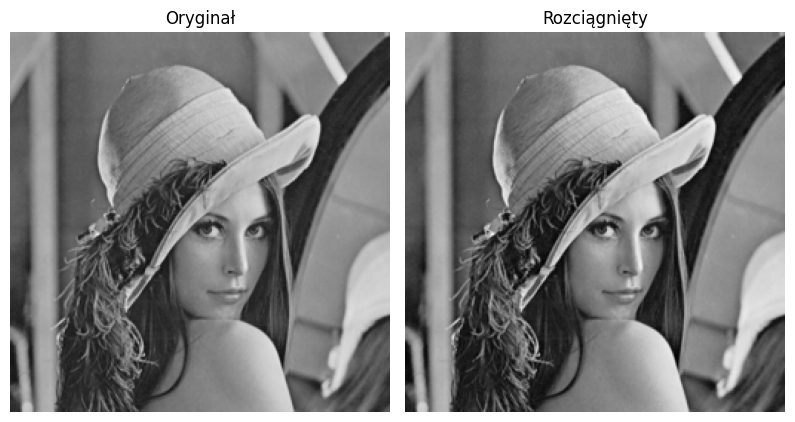

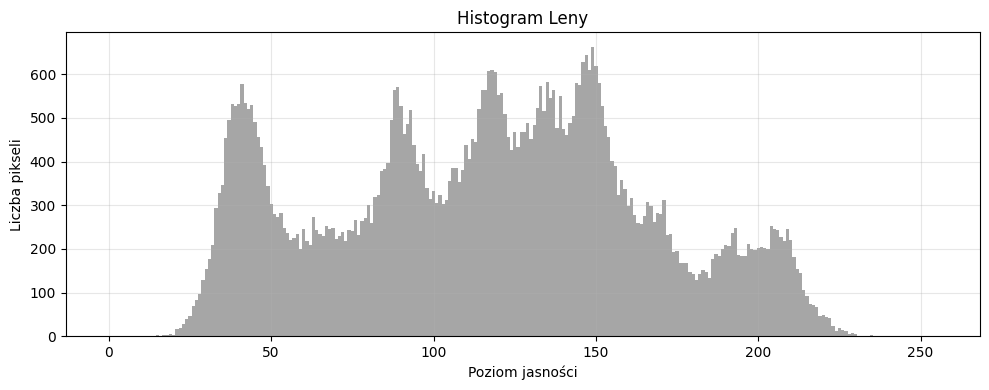

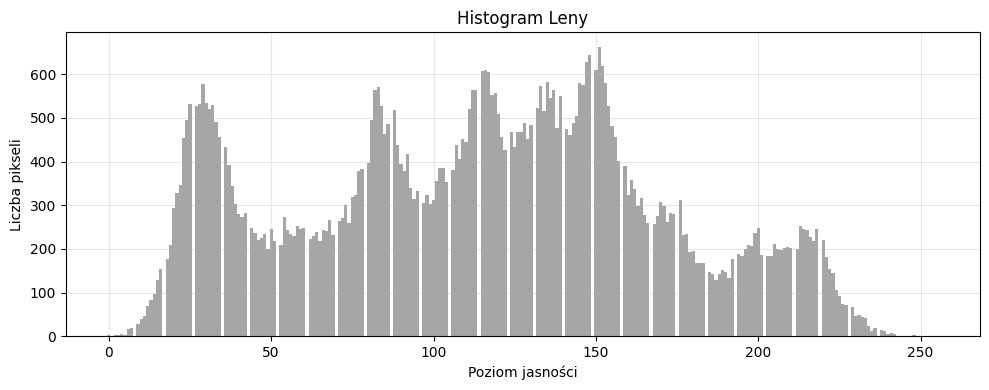

In [8]:
# ROZWIĄZANIE 2.1
def minmax_stretch(img_gray, in_range=None, out_range=(0, 255)):
    img = img_gray.astype(np.float64)

    if in_range is None:
        in_min, in_max = img.min(), img.max()
    else:
        in_min, in_max = in_range

    # Skalowanie liniowe
    img_stretched = (img - in_min) / (in_max - in_min) * (out_range[1] - out_range[0]) + out_range[0]

    # Obcięcie i konwersja
    img_stretched = np.clip(img_stretched, out_range[0], out_range[1])
    return img_stretched.astype(np.uint8)

# Test
if lena_small is not None:
    stretched = minmax_stretch(lena_small)
    print(f"✓ Przed: [{lena_small.min()}, {lena_small.max()}]")
    print(f"✓ Po: [{stretched.min()}, {stretched.max()}]")
    show_images([lena_small, stretched], ['Oryginał', 'Rozciągnięty'])

    hist, bins = compute_histogram(lena_small)
    plot_histogram(hist, title="Histogram Leny")
    hist, bins = compute_histogram(stretched)
    plot_histogram(hist, title="Histogram Leny")


#### 2.2 Metoda percentylowa

**Zadanie:** Rozciąganie z przycinaniem outlierów.

In [ ]:
# TODO: Zaimplementuj minmax_stretch_percentile
def minmax_stretch_percentile(img_gray, p_low=1, p_high=99, out_range=(0, 255)):
    """Rozciąganie z percentylami."""
    # TODO: Oblicz percentyle (np.percentile)
    # TODO: Użyj minmax_stretch z in_range=(p_low_val, p_high_val)
    pass

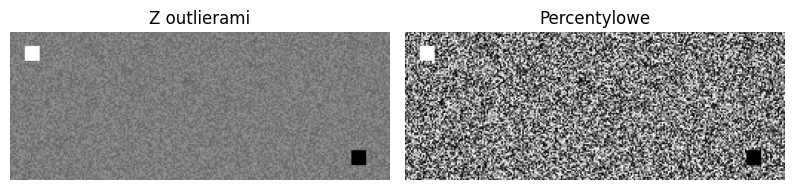

In [9]:
# ROZWIĄZANIE 2.2
def minmax_stretch_percentile(img_gray, p_low=1, p_high=99, out_range=(0, 255)):
    p_low_val = np.percentile(img_gray, p_low)
    p_high_val = np.percentile(img_gray, p_high)
    return minmax_stretch(img_gray, in_range=(p_low_val, p_high_val), out_range=out_range)

# Test z obrazem z outlierami
stretched_perc = minmax_stretch_percentile(outliers)
show_images([outliers, stretched_perc], ['Z outlierami', 'Percentylowe'])

---

### Zadanie 3: Progowanie globalne

#### 3.1 Progowanie binarne

**Zadanie:** Zaimplementuj progowanie z zadanym progiem.

In [ ]:
# TODO: Zaimplementuj threshold_global
def threshold_global(img_gray, thr, mode='binary', return_uint8=True):
    """
    Progowanie globalne.

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz wejściowy
    thr : float
        Wartość progu
    mode : str
        'binary' lub 'binary_inv'
    return_uint8 : bool
        Czy zwrócić uint8 (0/255) czy bool

    Zwraca:
    -------
    mask : numpy.ndarray
        Maska binarna
    """
    # TODO: Porównanie z progiem
    # TODO: Obsługa trybu binary/binary_inv
    # TODO: Konwersja do uint8 jeśli return_uint8=True
    pass

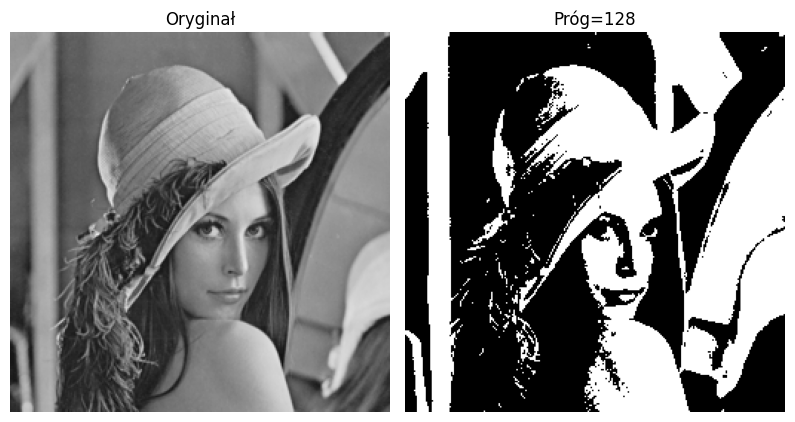

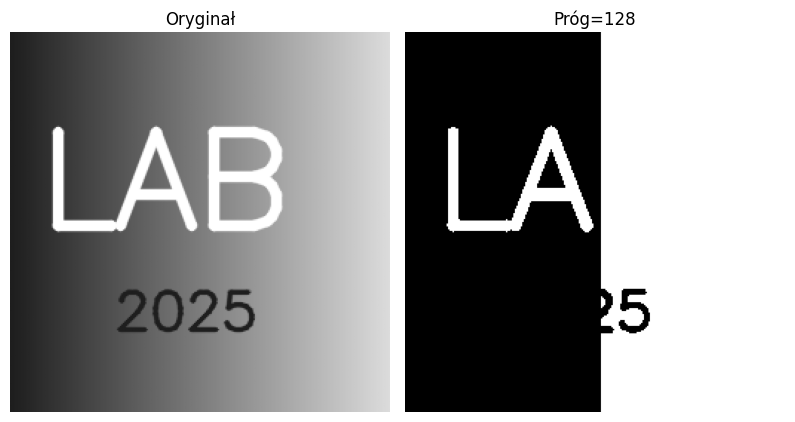

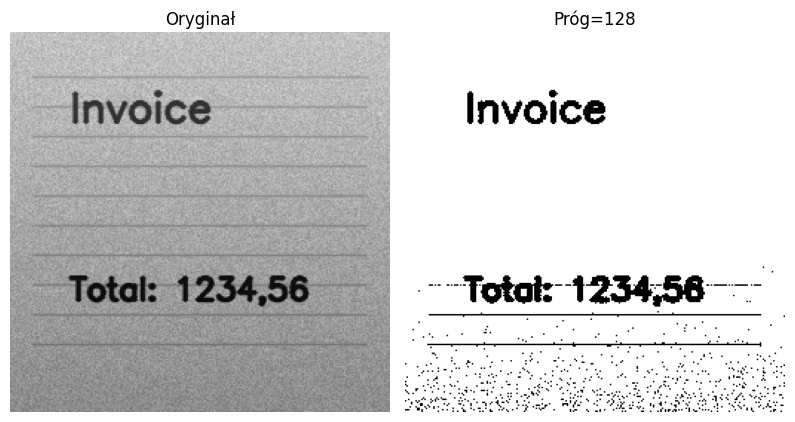

In [10]:
# ROZWIĄZANIE 3.1
def threshold_global(img_gray, thr, mode='binary', return_uint8=True):
    if mode == 'binary':
        mask = img_gray >= thr
    elif mode == 'binary_inv':
        mask = img_gray < thr
    else:
        raise ValueError("mode must be 'binary' or 'binary_inv'")

    if return_uint8:
        return (mask * 255).astype(np.uint8)
    return mask

# Test
if lena_small is not None:
    mask = threshold_global(lena_small, thr=128)
    show_images([lena_small, mask], ['Oryginał', 'Próg=128'])

img_test = [make_gradient_with_text(), make_noisy_doc()]
for img in img_test:
    mask = threshold_global(img, thr=128)
    show_images([img, mask], ['Oryginał', 'Próg=128'])

#### 3.2 Metoda Otsu

**Zadanie:** Zaimplementuj automatyczny dobór progu metodą Otsu.

In [ ]:
# TODO: Zaimplementuj threshold_otsu_value
def threshold_otsu_value(img_gray):
    """
    Oblicza optymalny próg metodą Otsu.

    Zwraca:
    -------
    best_thr : int
        Optymalny próg
    """
    # TODO: Oblicz histogram
    # TODO: Dla każdego t=0..255:
    #   - Podziel na dwie klasy
    #   - Oblicz wagi w0, w1
    #   - Oblicz średnie mu0, mu1
    #   - Oblicz wariancję międzyklasową sigma_b^2
    # TODO: Zwróć t z maksymalną sigma_b^2
    pass

Próg Otsu: 110


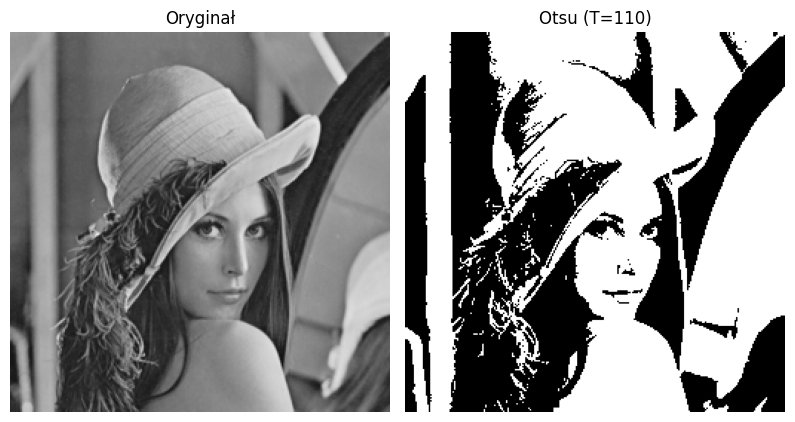

Próg Otsu: 132


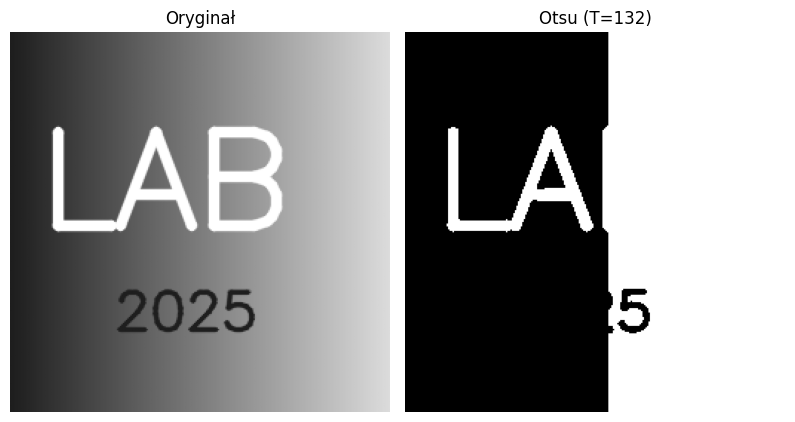

Próg Otsu: 101


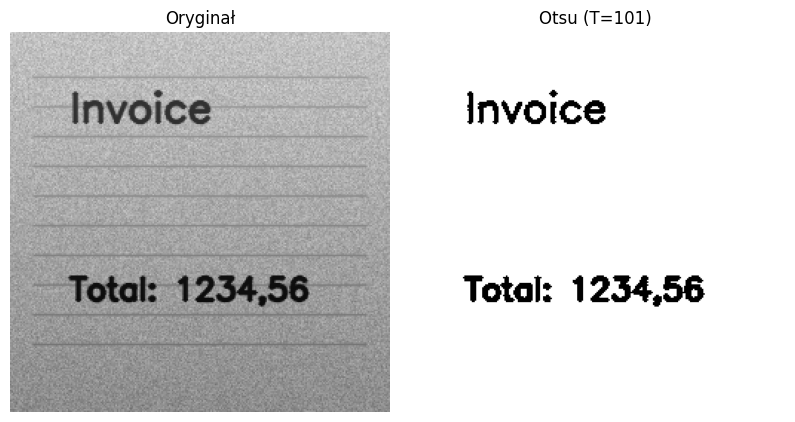

In [11]:
# ROZWIĄZANIE 3.2
def threshold_otsu_value(img_gray):
    hist, _ = compute_histogram(img_gray)
    hist = hist.astype(np.float64)
    total = hist.sum()

    best_thr = 0
    best_var = 0

    sum_total = np.dot(np.arange(256), hist)
    sum_bg = 0
    weight_bg = 0

    for t in range(256):
        weight_bg += hist[t]
        if weight_bg == 0:
            continue

        weight_fg = total - weight_bg
        if weight_fg == 0:
            break

        sum_bg += t * hist[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_total - sum_bg) / weight_fg

        var_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2

        if var_between > best_var:
            best_var = var_between
            best_thr = t

    return best_thr

# Test
if lena_small is not None:
    otsu_thr = threshold_otsu_value(lena_small)
    print(f"Próg Otsu: {otsu_thr}")
    mask_otsu = threshold_global(lena_small, otsu_thr)
    show_images([lena_small, mask_otsu], ['Oryginał', f'Otsu (T={otsu_thr})'])

img_test = [make_gradient_with_text(), make_noisy_doc()]
for img in img_test:
    otsu_thr = threshold_otsu_value(img)
    print(f"Próg Otsu: {otsu_thr}")
    mask_otsu = threshold_global(img, otsu_thr)
    show_images([img, mask_otsu], ['Oryginał', f'Otsu (T={otsu_thr})'])

---

### Zadanie 4: Progowanie adaptacyjne

#### 4.1 Metoda średniej

**Zadanie:** Zaimplementuj progowanie lokalne oparte na średniej w oknie.

In [ ]:
# TODO: Zaimplementuj threshold_local_mean
def threshold_local_mean(img_gray, block_size=35, c=0):
    """
    Progowanie adaptacyjne metodą średniej.

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz wejściowy
    block_size : int
        Rozmiar okna (nieparzysta liczba)
    c : float
        Stała korekcyjna odejmowana od średniej

    Zwraca:
    -------
    mask : numpy.ndarray
        Maska binarna (uint8)
    """
    # TODO: Dla każdego piksela:
    #   - Wyznacz okno block_size x block_size
    #   - Oblicz średnią w oknie
    #   - Próg lokalny = średnia - c
    #   - Porównaj piksel z progiem
    # Wskazówka: użyj padding (np.pad) dla brzegów
    pass

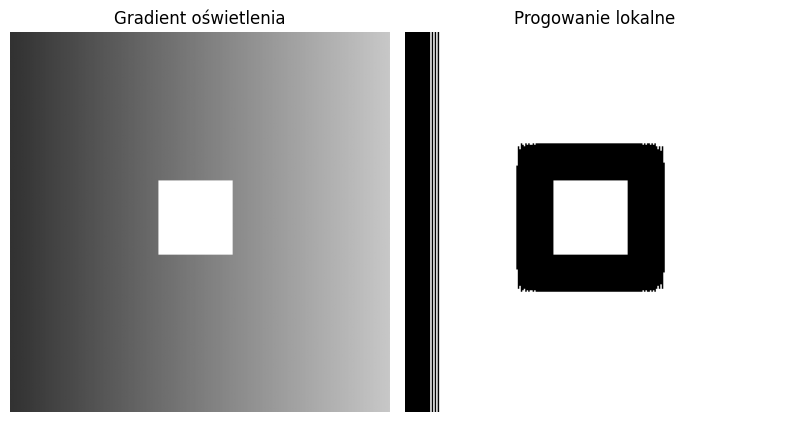

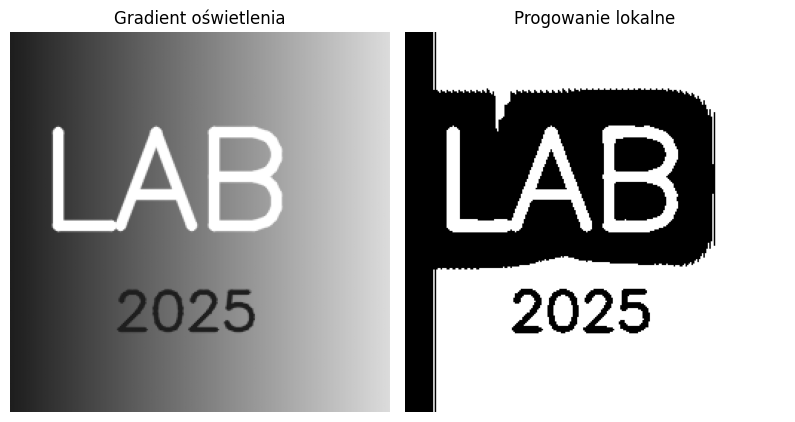

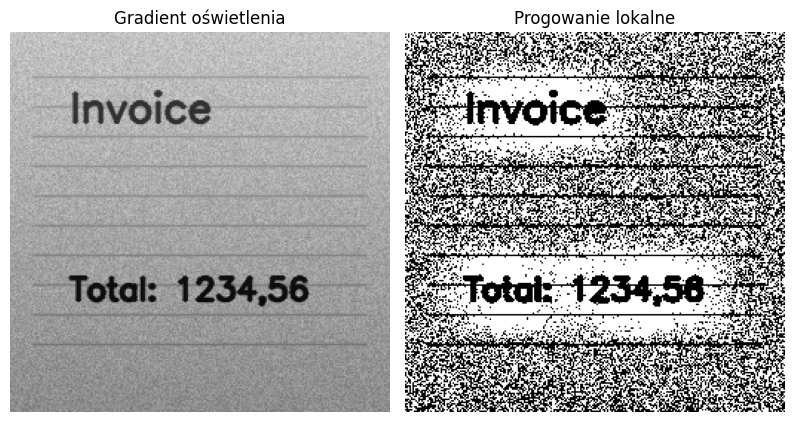

In [12]:
def threshold_local_mean(img_gray, block_size=35, c=0):
    import cv2

    # Średnia lokalna (filtr uśredniający)
    local_mean = cv2.blur(img_gray, (block_size, block_size))

    # Próg lokalny
    threshold = local_mean - c

    # Maska
    mask = img_gray >= threshold
    return (mask * 255).astype(np.uint8)

# Test - obraz z gradientem oświetlenia
gradient_light = np.tile(np.linspace(50, 200, 256), (256, 1)).astype(np.uint8)
gradient_light[100:150, 100:150] = 255  # jasny obiekt

mask_local = threshold_local_mean(gradient_light, block_size=51)
show_images([gradient_light, mask_local], ['Gradient oświetlenia', 'Progowanie lokalne'])

img_test = [make_gradient_with_text(), make_noisy_doc()]
for img in img_test:
    mask_local = threshold_local_mean(img, block_size=51)
    show_images([img, mask_local], ['Gradient oświetlenia', 'Progowanie lokalne'])

---

### Zadanie 5: Pipeline – histogram → próg → segmentacja

**Zadanie:** Zaimplementuj kompletny pipeline:
1. Oszacowanie progu z histogramu (metoda dwóch pików lub ISODATA)
2. Rozciąganie percentylowe (jeśli potrzebne)
3. Progowanie
4. Czyszczenie maski (operacje morfologiczne)

#### 5.1 Oszacowanie progu z histogramu

In [ ]:
# TODO: Zaimplementuj threshold_from_histogram_peaks
def threshold_from_histogram_peaks(img_gray, smooth_window=5):
    """
    Oszacowanie progu z histogramu - metoda dwóch pików.

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz wejściowy
    smooth_window : int
        Rozmiar okna do wygładzenia histogramu

    Zwraca:
    -------
    thr : int
        Oszacowany próg
    """
    # TODO: Oblicz histogram
    # TODO: Wygładź histogram (np. np.convolve z oknem prostokątnym)
    # TODO: Znajdź dwa największe maksima lokalne
    # TODO: Znajdź minimum między nimi
    pass

# TODO: Zaimplementuj threshold_isodata
def threshold_isodata(img_gray, max_iter=100, tol=0.5):
    """
    Oszacowanie progu metodą ISODATA (iteracyjną).

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz wejściowy
    max_iter : int
        Maksymalna liczba iteracji
    tol : float
        Tolerancja zbieżności

    Zwraca:
    -------
    thr : int
        Oszacowany próg
    """
    # TODO: Początkowy próg = średnia jasność
    # TODO: Iteracyjnie:
    #   - Podziel na dwie klasy (< T i >= T)
    #   - Oblicz średnie mu0, mu1
    #   - Nowy próg T = (mu0 + mu1) / 2
    #   - Sprawdź zbieżność |T_new - T_old| < tol
    pass

Próg (piki): 125
Próg (ISODATA): 111


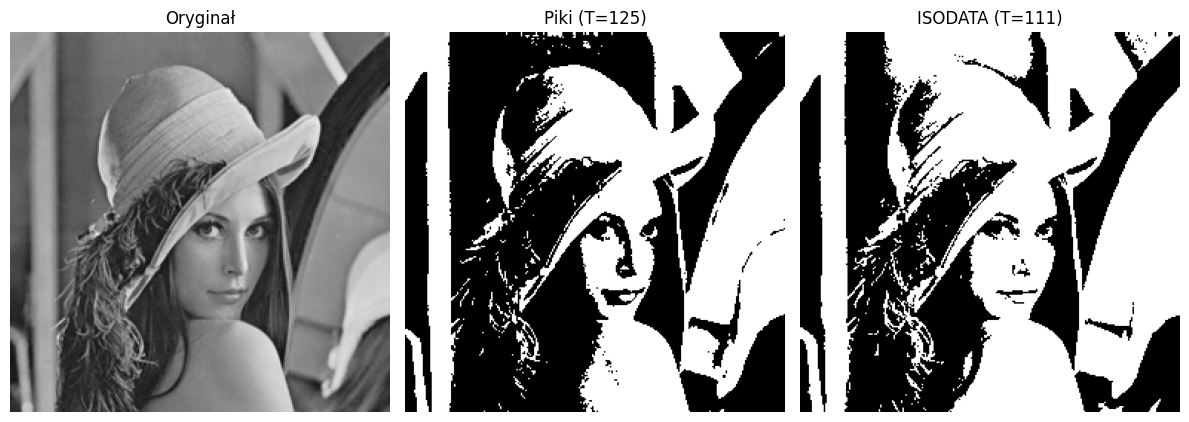

Próg (piki): 80
Próg (ISODATA): 130


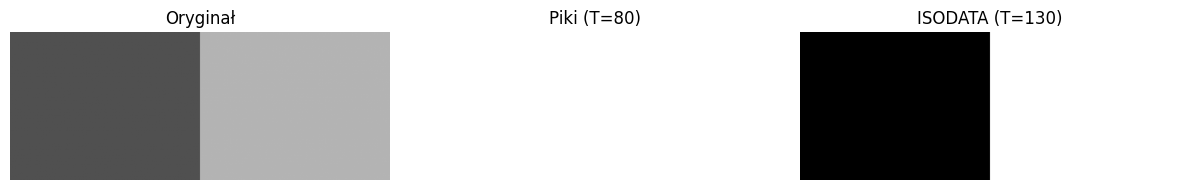

Próg (piki): 43
Próg (ISODATA): 154


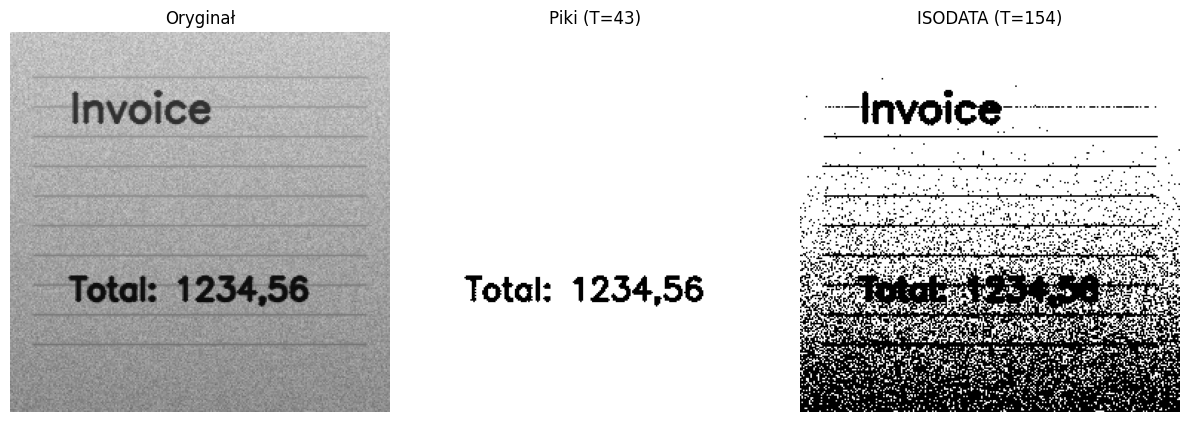

Próg (piki): 210
Próg (ISODATA): 117


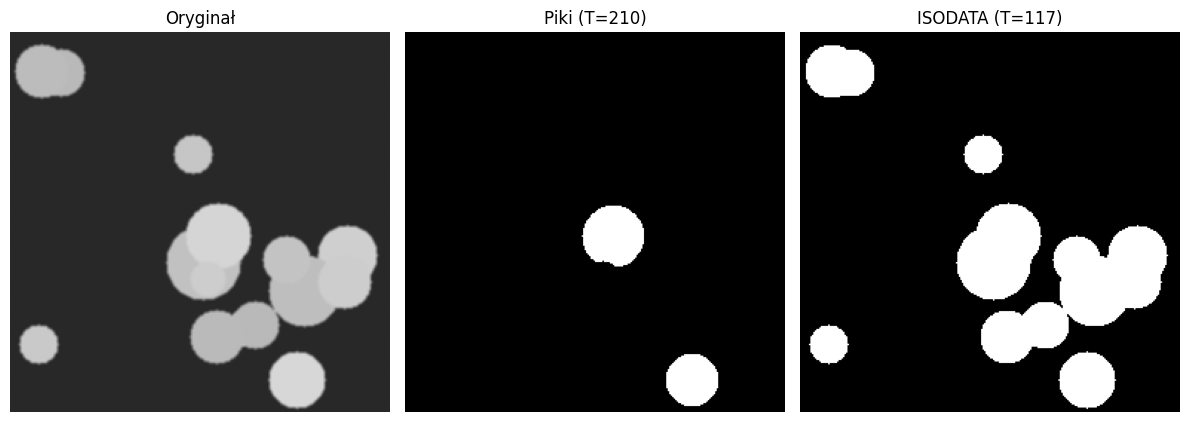

Próg (piki): 121
Próg (ISODATA): 119


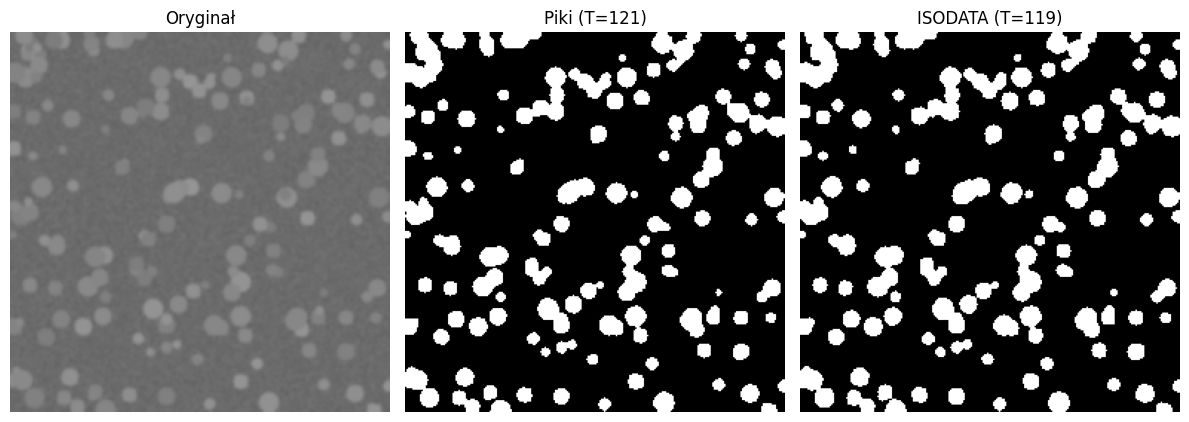

In [ ]:
# ROZWIĄZANIE 5.1
def threshold_from_histogram_peaks(img_gray, smooth_window=5):
    hist, _ = compute_histogram(img_gray)

    # Wygładzenie
    kernel = np.ones(smooth_window) / smooth_window
    hist_smooth = np.convolve(hist, kernel, mode='same')

    # Znajdź maksima lokalne (bez scipy)
    peaks = []
    distance = 20
    
    for i in range(1, len(hist_smooth) - 1):
        # Sprawdź czy punkt jest lokalnym maksimum
        if hist_smooth[i] > hist_smooth[i-1] and hist_smooth[i] > hist_smooth[i+1]:
            # Sprawdź odległość od poprzednich pików
            if len(peaks) == 0 or i - peaks[-1] >= distance:
                peaks.append(i)
    
    peaks = np.array(peaks)

    if len(peaks) < 2:
        # Fallback: Otsu
        return threshold_otsu_value(img_gray)

    # Dwa największe piki
    peak_vals = hist_smooth[peaks]
    top_two_idx = np.argsort(peak_vals)[-2:]
    peak1, peak2 = sorted(peaks[top_two_idx])

    # Minimum między pikami
    valley_idx = peak1 + np.argmin(hist_smooth[peak1:peak2+1])
    return valley_idx

def threshold_isodata(img_gray, max_iter=100, tol=0.5):
    # Początkowy próg
    T = img_gray.mean()

    for _ in range(max_iter):
        # Podział na klasy
        class0 = img_gray[img_gray < T]
        class1 = img_gray[img_gray >= T]

        if len(class0) == 0 or len(class1) == 0:
            break

        # Średnie
        mu0 = class0.mean()
        mu1 = class1.mean()

        # Nowy próg
        T_new = (mu0 + mu1) / 2

        # Zbieżność
        if abs(T_new - T) < tol:
            break

        T = T_new

    return int(T)

# Test
if lena_small is not None:
    thr_peaks = threshold_from_histogram_peaks(lena_small)
    thr_isodata = threshold_isodata(lena_small)
    print(f"Próg (piki): {thr_peaks}")
    print(f"Próg (ISODATA): {thr_isodata}")

    mask_peaks = threshold_global(lena_small, thr_peaks)
    mask_isodata = threshold_global(lena_small, thr_isodata)
    show_images([lena_small, mask_peaks, mask_isodata], 
                ['Oryginał', f'Piki (T={thr_peaks})', f'ISODATA (T={thr_isodata})'])

img_test = [bimodal,  make_noisy_doc(),make_bimodal_objects(),make_low_contrast_cells()]
for img in img_test:
    thr_peaks = threshold_from_histogram_peaks(img)
    thr_isodata = threshold_isodata(img)
    print(f"Próg (piki): {thr_peaks}")
    print(f"Próg (ISODATA): {thr_isodata}")

    mask_peaks = threshold_global(img, thr_peaks)
    mask_isodata = threshold_global(img, thr_isodata)
    show_images([img, mask_peaks, mask_isodata], 
            ['Oryginał', f'Piki (T={thr_peaks})', f'ISODATA (T={thr_isodata})'])

#### 5.2 Kompletny pipeline

In [ ]:
# TODO: Zaimplementuj segmentation_pipeline
def segmentation_pipeline(img_gray, method='peaks', use_stretch=True, use_morph=True):
    """
    Kompletny pipeline segmentacji.

    Parametry:
    ----------
    img_gray : numpy.ndarray
        Obraz wejściowy
    method : str
        'peaks' lub 'isodata'
    use_stretch : bool
        Czy zastosować rozciąganie percentylowe
    use_morph : bool
        Czy zastosować operacje morfologiczne (czyszczenie)

    Zwraca:
    -------
    mask_final : numpy.ndarray
        Maska po segmentacji
    stats : dict
        Statystyki (próg, liczba komponentów, procent obiektu)
    """
    # TODO: Krok 1 - Rozciąganie (opcjonalne)
    # TODO: Krok 2 - Oszacowanie progu
    # TODO: Krok 3 - Progowanie
    # TODO: Krok 4 - Czyszczenie morfologiczne (opcjonalne)
    #   - Otwarcie (erozja + dylatacja) - usuwa małe obiekty
    #   - Zamknięcie (dylatacja + erozja) - wypełnia dziury
    # TODO: Krok 5 - Statystyki
    pass

Próg: 113
Procent obiektu: 54.39%
Liczba komponentów: 17


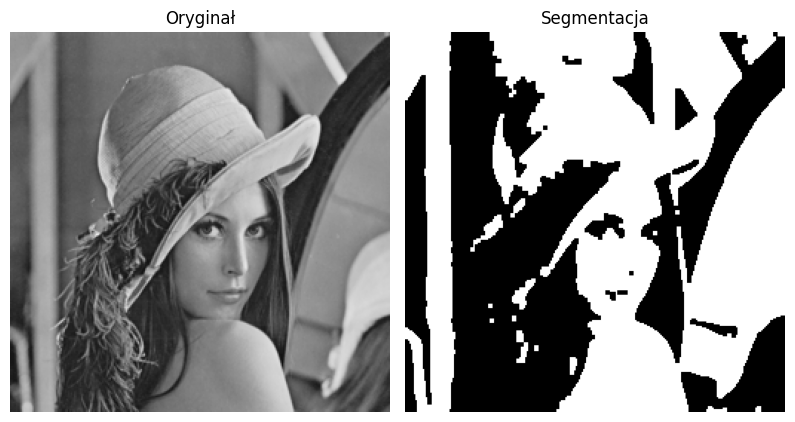

Próg: 114
Procent obiektu: 49.49%
Liczba komponentów: 2


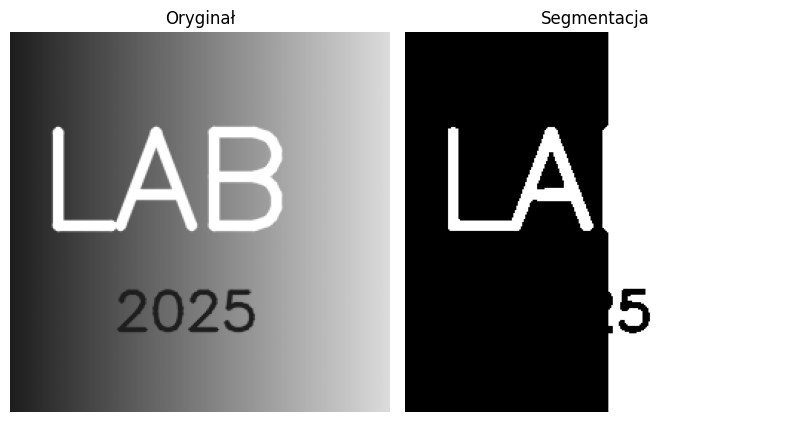

Próg: 177
Procent obiektu: 50.32%
Liczba komponentów: 50


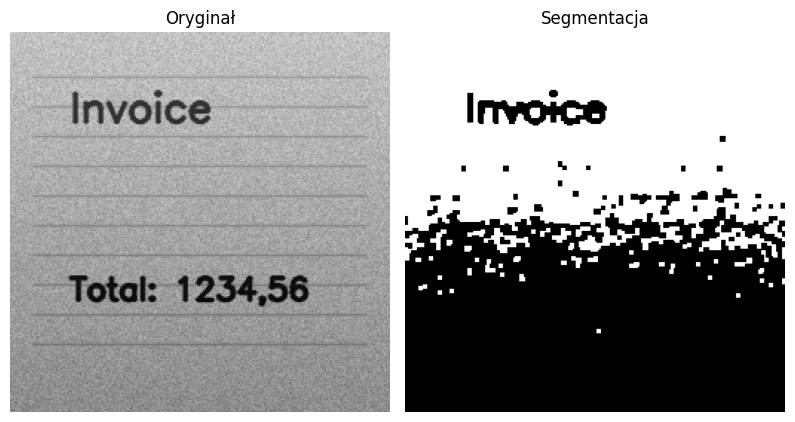

In [21]:
# ROZWIĄZANIE 5.2
def binary_erosion_simple(mask, kernel_size=3):
    """Prosta erozja binarna (bez scipy)."""
    import cv2
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.erode(mask.astype(np.uint8), kernel, iterations=1).astype(bool)

def binary_dilation_simple(mask, kernel_size=3):
    """Prosta dylatacja binarna (bez scipy)."""
    import cv2
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.dilate(mask.astype(np.uint8), kernel, iterations=1).astype(bool)

def count_components(mask):
    """Zlicza komponenty spójne bez scipy."""
    import cv2
    num_labels, labels = cv2.connectedComponents(mask.astype(np.uint8))
    return num_labels - 1  # Odejmujemy tło

def segmentation_pipeline(img_gray, method='peaks', use_stretch=True, use_morph=True):
    stats = {}

    # Krok 1: Rozciąganie
    if use_stretch:
        img_proc = minmax_stretch_percentile(img_gray, p_low=2, p_high=98)
    else:
        img_proc = img_gray

    # Krok 2: Oszacowanie progu
    if method == 'peaks':
        thr = threshold_from_histogram_peaks(img_proc)
    elif method == 'isodata':
        thr = threshold_isodata(img_proc)
    else:
        thr = threshold_otsu_value(img_proc)

    stats['threshold'] = thr

    # Krok 3: Progowanie
    mask = threshold_global(img_proc, thr, return_uint8=False)

    # Krok 4: Czyszczenie morfologiczne
    if use_morph:
        # Otwarcie (usuwa małe obiekty)
        mask = binary_erosion_simple(mask, kernel_size=3)
        mask = binary_dilation_simple(mask, kernel_size=3)
        # Zamknięcie (wypełnia dziury)
        mask = binary_dilation_simple(mask, kernel_size=3)
        mask = binary_erosion_simple(mask, kernel_size=3)

    mask_final = (mask * 255).astype(np.uint8)

    # Krok 5: Statystyki
    stats['object_percent'] = (mask.sum() / mask.size) * 100

    # Liczba komponentów
    stats['num_components'] = count_components(mask)

    return mask_final, stats

# Test
if lena_small is not None:
    mask_final, stats = segmentation_pipeline(lena_small, method='isodata', use_morph=True)
    print(f"Próg: {stats['threshold']}")
    print(f"Procent obiektu: {stats['object_percent']:.2f}%")
    print(f"Liczba komponentów: {stats['num_components']}")
    show_images([lena_small, mask_final], ['Oryginał', 'Segmentacja'])

# Test
img_test = [make_gradient_with_text(), make_noisy_doc()]
for img in img_test:
    mask_final, stats = segmentation_pipeline(img, method='isodata', use_morph=True)
    print(f"Próg: {stats['threshold']}")
    print(f"Procent obiektu: {stats['object_percent']:.2f}%")
    print(f"Liczba komponentów: {stats['num_components']}")
    show_images([img, mask_final], ['Oryginał', 'Segmentacja'])

---

## 4. Przykłady użycia (Case Studies)

### Case Study 1: Słabo skontrastowany dokument

Dokument - Próg: 119, Obiekt: 19.6%


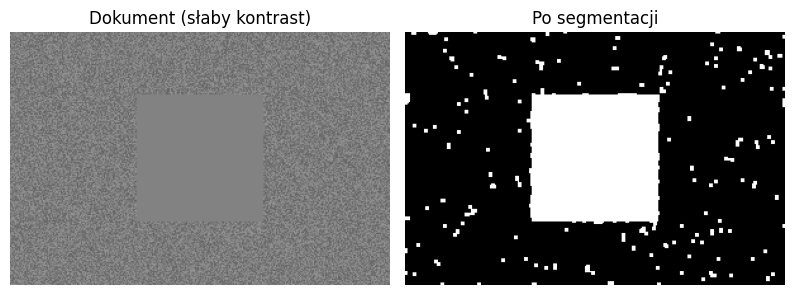

In [27]:
# Symulacja słabo skontrastowanego dokumentu
doc = np.random.randint(100, 150, (200, 300), dtype=np.uint8)
doc[50:150, 100:200] = 130  # tekst

# Pipeline
mask_doc, stats_doc = segmentation_pipeline(doc, method='isodata', use_stretch=True)
print(f"Dokument - Próg: {stats_doc['threshold']}, Obiekt: {stats_doc['object_percent']:.1f}%")
show_images([doc, mask_doc], ['Dokument (słaby kontrast)', 'Po segmentacji'])

### Case Study 2: Nierównomierne oświetlenie

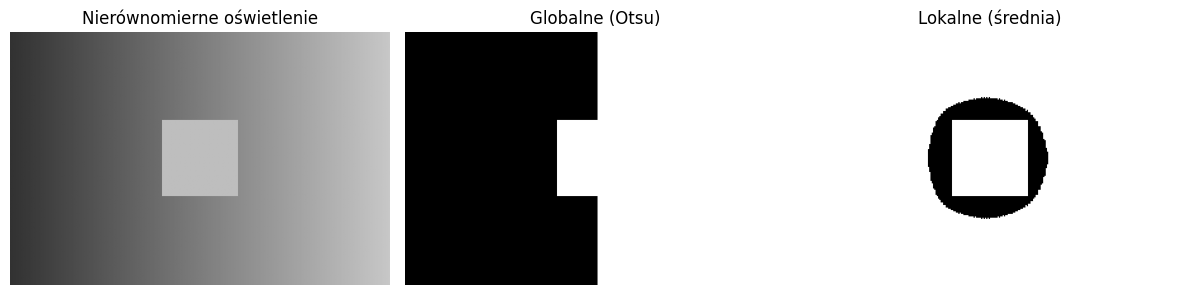

In [41]:
# Obraz z gradientem oświetlenia
uneven = np.tile(np.linspace(50, 200, 300), (200, 1)).astype(np.uint8)
uneven[70:130, 120:180] = 190  # jasny obiekt

# Progowanie globalne vs lokalne
mask_global = threshold_global(uneven, threshold_otsu_value(uneven))
mask_local = threshold_local_mean(uneven, block_size=51, c=10)

show_images([uneven, mask_global, mask_local], 
            ['Nierównomierne oświetlenie', 'Globalne (Otsu)', 'Lokalne (średnia)'])

---

## Podsumowanie

W tym laboratorium zaimplementowaliśmy:

1. **Histogram i CDF** – analiza rozkładu jasności
2. **Rozciąganie histogramu** – poprawa kontrastu (min-max, percentylowe)
3. **Progowanie globalne** – segmentacja z zadanym progiem i metodą Otsu
4. **Progowanie adaptacyjne** – radzenie sobie z nierównomiernym oświetleniem
5. **Pipeline segmentacji** – oszacowanie progu z histogramu + czyszczenie morfologiczne

**Kluczowe wnioski:**
- Histogram to podstawowe narzędzie analizy obrazu
- Rozciąganie poprawia kontrast, ale percentylowe jest bardziej odporne na outliery
- Otsu działa dobrze dla obrazów bimodalnych
- Progowanie adaptacyjne jest niezbędne przy zmiennym oświetleniu
- Operacje morfologiczne czyszczą maskę z szumu

**Dalsze kroki:**
- Wyrównywanie histogramu (histogram equalization)
- Progowanie wielopoziomowe
- Zaawansowane operacje morfologiczne
- Segmentacja oparta na regionach